In [1]:
import pickle
import numpy as np

with open("./results/gridsearch/params_search.pkl", "rb") as f:
    result = pickle.load(f)

tau = [comp["tau"] for comp in result["state"]]
b_limit = result["b_limit"]
q_limit = result["q_limit"]
n_limit = result["n_limit"]
f_limit = result["f_limit"]
i_limit = result["i_limit"]
tbr = np.array([result["state"][idx]["TBR"] for idx in range(len(tau))])
T = np.array([result["control"][idx]["T_avg"] for idx in range(len(tau))])

tau = np.array(tau)
b_limit = np.array(b_limit)
q_limit = np.array(q_limit)
n_limit = np.array(n_limit)
f_limit = np.array(f_limit)
i_limit = np.array(i_limit)

Qs = np.array([comp['Q'] for comp in result['state']])
indices = np.where(((b_limit == 1) * (n_limit == 1) * (q_limit == 1) * (f_limit == 1) * (tbr >= 1) * (Qs > 10.0)) == 1)
# print("indices : ", indices[0])
print("# of feasible solutions with Q > 10:", len(indices[0]))
print('percentage of feasible solutions: {:.2f}'.format(100 * len(indices[0]) / len(tau)))

# of feasible solutions with Q > 10: 313
percentage of feasible solutions: 3.13


In [2]:
# The minimum cost case
cost = np.array([result["cost"][idx] for idx in indices[0]])

arg_min = np.argmin(cost)
arg_min = indices[0][arg_min]

for key in result["state"][arg_min].keys():
    print("{} : {:.3f}".format(key, result["state"][arg_min][key]))

for key in result["control"][arg_min].keys():
    print("{} : {:.3f}".format(key, result["control"][arg_min][key]))

R : 4.902
a : 1.390
blanket_thickness : 1.183
coil_thickness : 0.863
n : 1.373
TBR : 2.532
beta : 5.750
tau : 0.978
Ip : 12.662
q : 2.047
li : 0.025
f_BS : 0.679
Q_parallel : 471.794
n_g : 2.085
q_kink : 2.000
beta_troyon : 5.897
f_NC : 0.729
n_tau : 1.343
n_tau_lower : 2.212
cost : 0.863
Q : 10.559
betan : 3.692
k : 1.900
epsilon : 3.526
electric_power : 1038461538.462
T_avg : 14.103
B0 : 12.000
H : 1.254
armour_thickness : 0.023
RF_recirculating_rate : 0.190


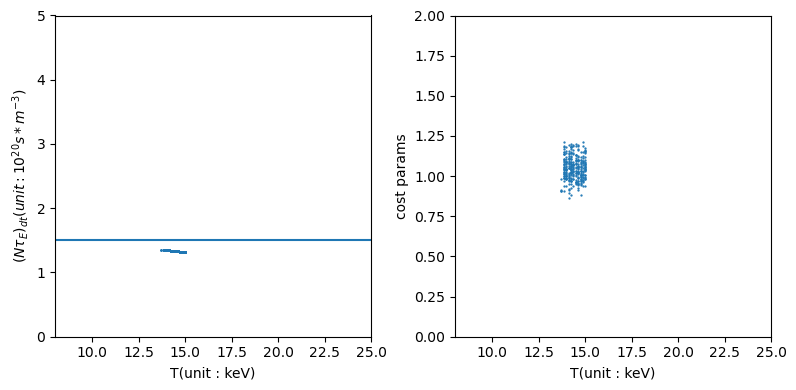

In [3]:
# n*tau*T graph
import matplotlib.pyplot as plt

# Lawson-criteria
T = np.array([result["control"][idx]["T_avg"] for idx in indices[0]])
n_tau = np.array([result["state"][idx]["n_tau"] for idx in indices[0]])
n_tau_T = T * n_tau

# Cost paramter
cost = np.array([result["state"][idx]["cost"] for idx in indices[0]])

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes = axes.ravel()
ax = axes[0]
ax.scatter(T, n_tau, s = 0.4)
ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("$(N\\tau_E)_{dt}(unit:10^{20}s * m^{-3})$")
ax.axhline(1.5, 0, 1)
ax.set_xlim([8, 25])
ax.set_ylim([0, 5])

ax = axes[1]
ax.scatter(T, cost, s = 0.4)
ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("cost params")
ax.set_xlim([8, 25])
ax.set_ylim([0, 2])

fig.tight_layout()

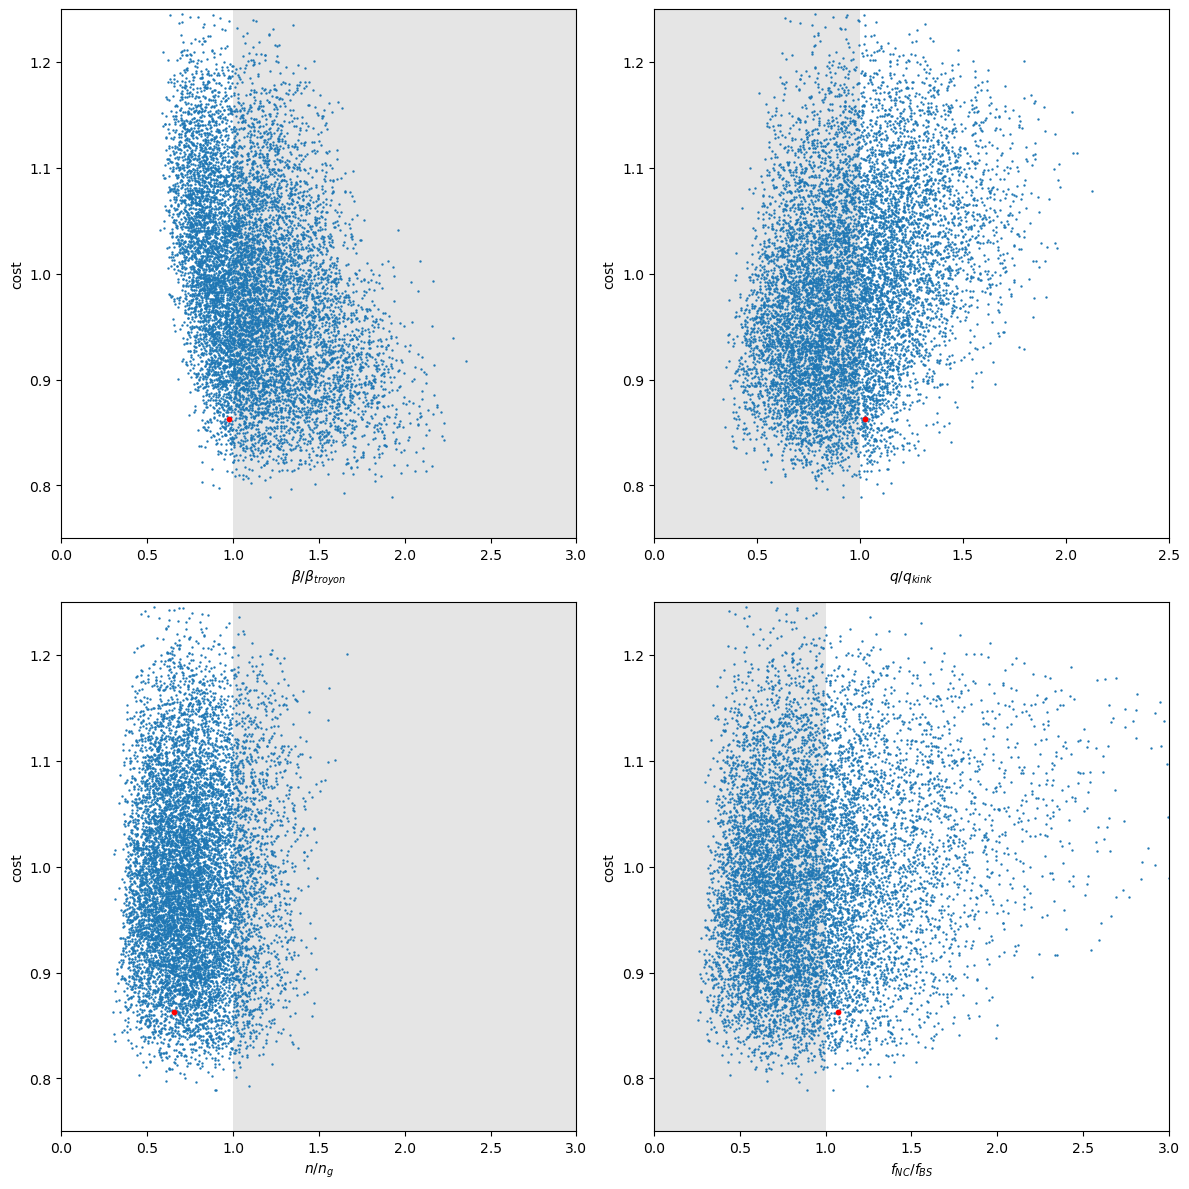

In [4]:
from src.analysis.plot import plot_scatter_feasibility

fig, axes = plot_scatter_feasibility(
    result, yparam="cost", ylabel="cost", ylims=[0.75, 1.25], filename=None
)

optim_status = result["state"][arg_min]
b_ratio = optim_status["beta"] / optim_status["beta_troyon"]
q_ratio = optim_status["q"] / optim_status["q_kink"]
n_ratio = optim_status["n"] / optim_status["n_g"]
f_ratio = optim_status["f_NC"] / optim_status["f_BS"]
cost = optim_status['cost']

axes[0].scatter(b_ratio, cost, s=10.0, c='r')
axes[1].scatter(q_ratio, cost, s=10.0, c="r")
axes[2].scatter(n_ratio, cost, s=10.0, c="r")
axes[3].scatter(f_ratio, cost, s=10.0, c="r")

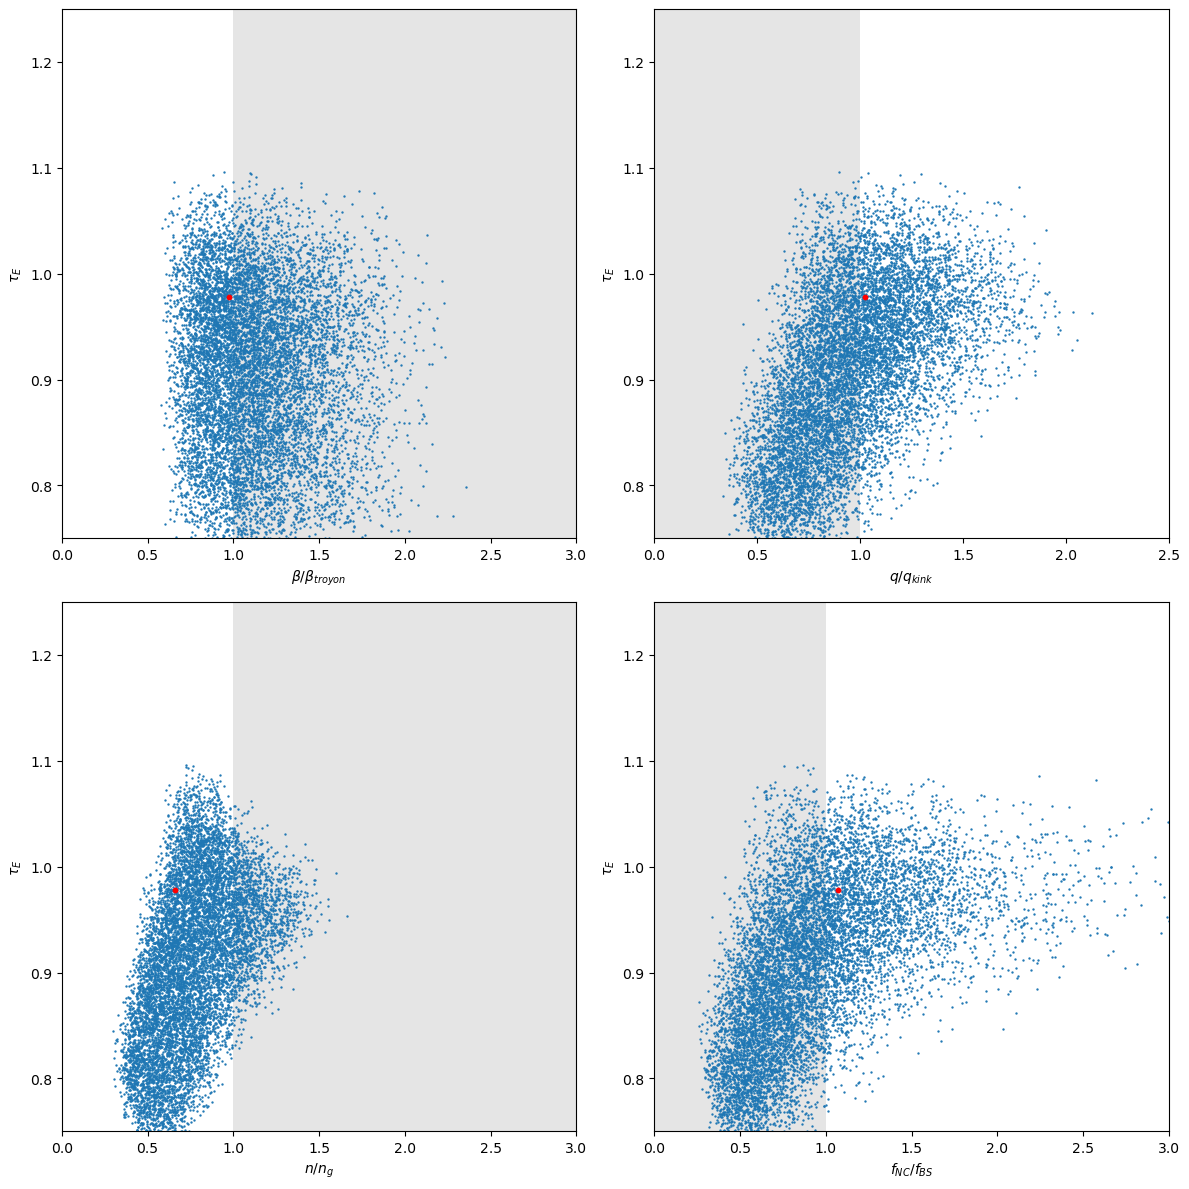

In [5]:
from src.analysis.plot import plot_scatter_feasibility

fig, axes = plot_scatter_feasibility(
    result, yparam="tau", ylabel=r"$\tau_E$", ylims=[0.75, 1.25], filename=None
)

optim_status = result["state"][arg_min]
b_ratio = optim_status["beta"] / optim_status["beta_troyon"]
q_ratio = optim_status["q"] / optim_status["q_kink"]
n_ratio = optim_status["n"] / optim_status["n_g"]
f_ratio = optim_status["f_NC"] / optim_status["f_BS"]
tau = optim_status["tau"]

axes[0].scatter(b_ratio, tau, s=10.0, c="r")
axes[1].scatter(q_ratio, tau, s=10.0, c="r")
axes[2].scatter(n_ratio, tau, s=10.0, c="r")
axes[3].scatter(f_ratio, tau, s=10.0, c="r")

In [6]:
n_operation = result["state"][arg_min]["n"]
tau_operation = result["state"][arg_min]["tau"]
T_operation = result["control"][arg_min]["T_avg"]
Q_operation = result["state"][arg_min]["Q"]
cost_operation = result['state'][arg_min]['cost']

status_grid = {
    "n":n_operation,
    "T":T_operation,
    "tau":tau_operation,
    "Q":Q_operation,
    "tag":"Gridsearch",
    "c":"r",
    "cost":cost_operation,
    "state":result['state']   
}

In [7]:
import pickle
import numpy as np

with open("./results/genetic/params_search.pkl", "rb") as f:
    result = pickle.load(f)

tau = [comp["tau"] for comp in result["state"]]
b_limit = result["b_limit"]
q_limit = result["q_limit"]
n_limit = result["n_limit"]
f_limit = result["f_limit"]
i_limit = result["i_limit"]
tbr = np.array([result["state"][idx]["TBR"] for idx in range(len(tau))])
T = np.array([result["control"][idx]["T_avg"] for idx in range(len(tau))])

tau = np.array(tau)
b_limit = np.array(b_limit)
q_limit = np.array(q_limit)
n_limit = np.array(n_limit)
f_limit = np.array(f_limit)
i_limit = np.array(i_limit)

Qs = np.array([comp['Q'] for comp in result['state']])
indices = np.where(((b_limit == 1) * (n_limit == 1) * (q_limit == 1) * (f_limit == 1) * (tbr >= 1) * (Qs > 10.0)) == 1)
# print("indices : ", indices[0])
print("# of feasible solutions with Q > 10:", len(indices[0]))
print('percentage of feasible solutions: {:.2f}'.format(100 * len(indices[0]) / len(tau)))

# of feasible solutions with Q > 10: 9598
percentage of feasible solutions: 95.98


In [8]:
# The minimum cost case
cost = np.array([result["cost"][idx] for idx in indices[0]])

arg_min = np.argmin(cost)
arg_min = indices[0][arg_min]

for key in result["state"][arg_min].keys():
    print("{} : {:.3f}".format(key, result["state"][arg_min][key]))

for key in result["control"][arg_min].keys():
    print("{} : {:.3f}".format(key, result["control"][arg_min][key]))

R : 5.870
a : 1.677
blanket_thickness : 1.164
coil_thickness : 0.991
n : 1.202
TBR : 1.763
beta : 3.765
tau : 1.097
Ip : 15.365
q : 2.443
li : 0.021
f_BS : 0.563
Q_parallel : 678.437
n_g : 1.739
q_kink : 2.000
beta_troyon : 3.774
f_NC : 0.673
n_tau : 1.319
n_tau_lower : 2.083
cost : 0.886
Q : 11.776
betan : 2.800
k : 1.900
epsilon : 3.500
electric_power : 1500.000
T_avg : 15.000
B0 : 13.173
H : 1.091
armour_thickness : 0.050
RF_recirculating_rate : 0.171


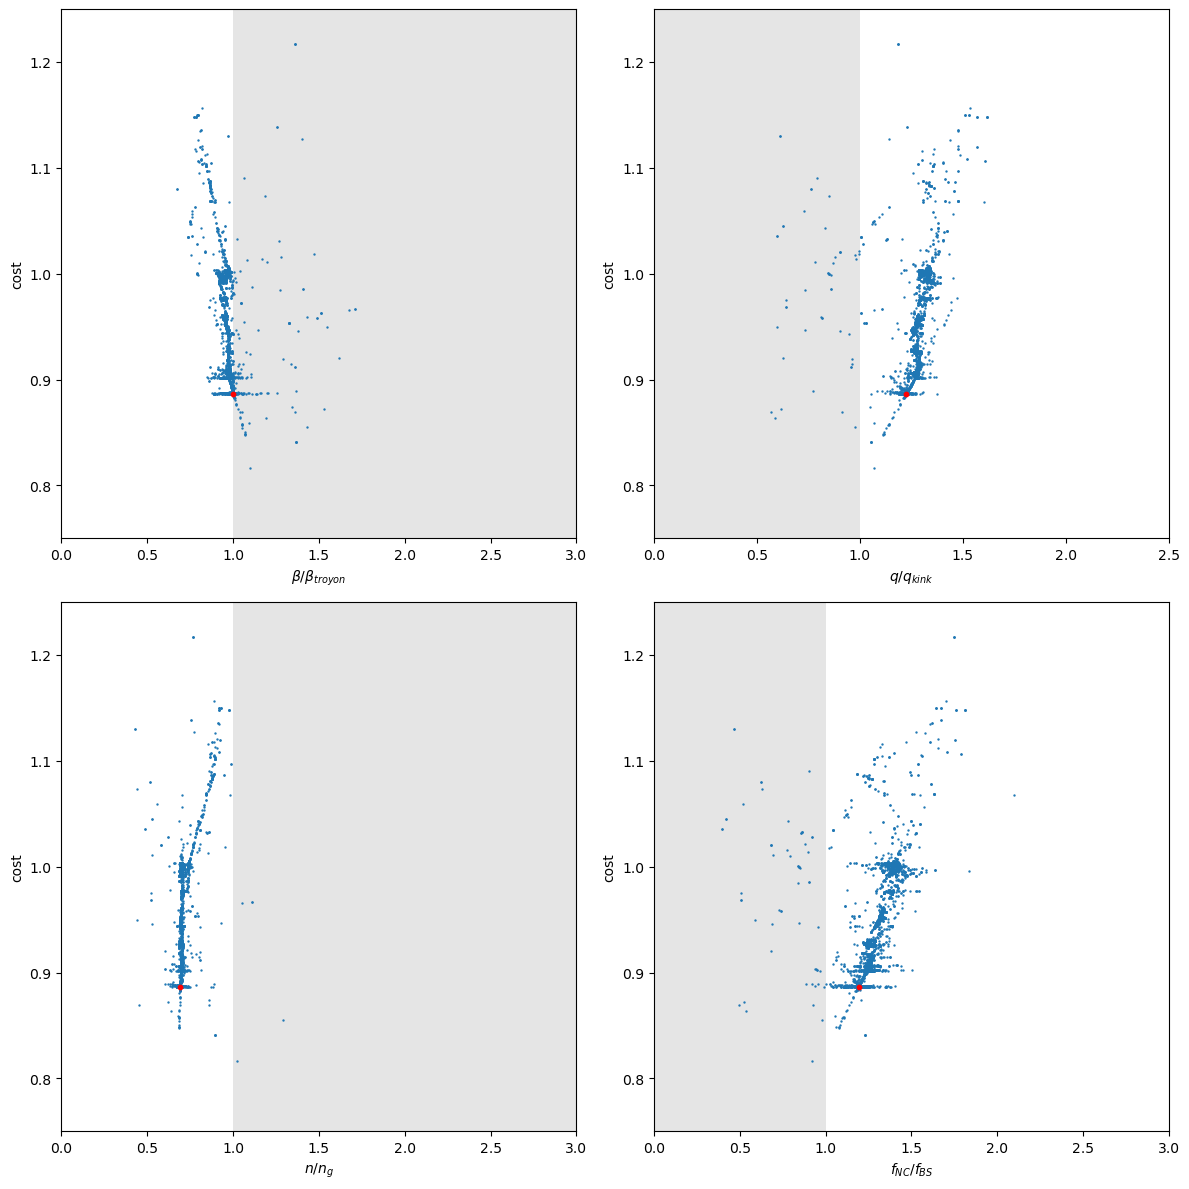

In [9]:
from src.analysis.plot import plot_scatter_feasibility

fig, axes = plot_scatter_feasibility(
    result, yparam="cost", ylabel="cost", ylims=[0.75, 1.25], filename=None
)

optim_status = result["state"][arg_min]
b_ratio = optim_status["beta"] / optim_status["beta_troyon"]
q_ratio = optim_status["q"] / optim_status["q_kink"]
n_ratio = optim_status["n"] / optim_status["n_g"]
f_ratio = optim_status["f_NC"] / optim_status["f_BS"]
cost = optim_status["cost"]

axes[0].scatter(b_ratio, cost, s=10.0, c="r")
axes[1].scatter(q_ratio, cost, s=10.0, c="r")
axes[2].scatter(n_ratio, cost, s=10.0, c="r")
axes[3].scatter(f_ratio, cost, s=10.0, c="r")

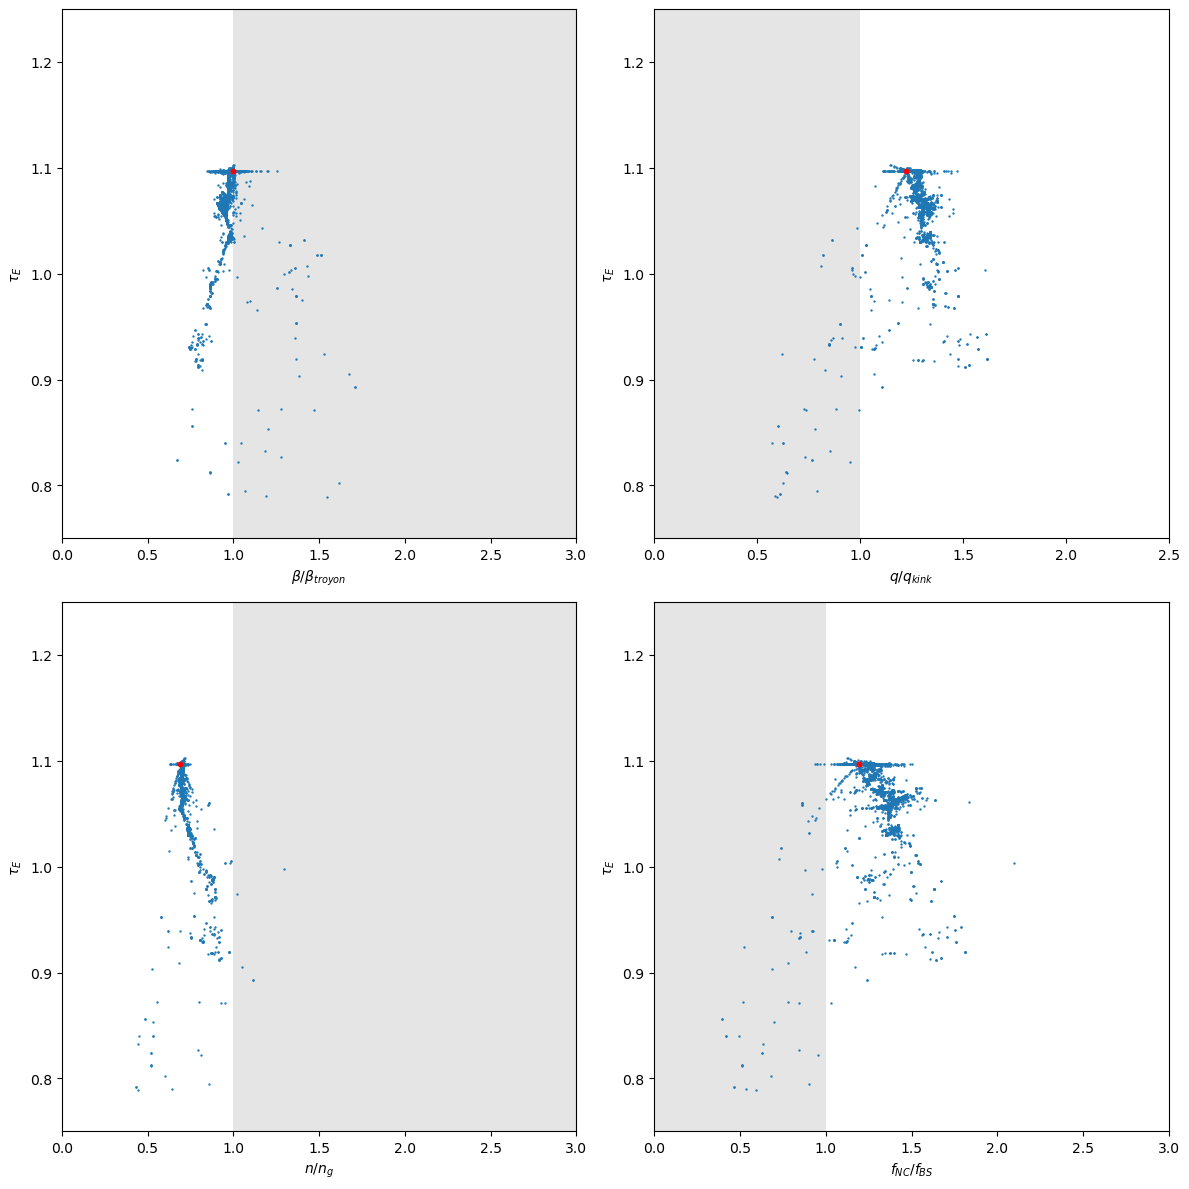

In [10]:
from src.analysis.plot import plot_scatter_feasibility

fig, axes = plot_scatter_feasibility(
    result, yparam="tau", ylabel=r"$\tau_E$", ylims=[0.75, 1.25], filename=None
)

optim_status = result["state"][arg_min]
b_ratio = optim_status["beta"] / optim_status["beta_troyon"]
q_ratio = optim_status["q"] / optim_status["q_kink"]
n_ratio = optim_status["n"] / optim_status["n_g"]
f_ratio = optim_status["f_NC"] / optim_status["f_BS"]
tau = optim_status["tau"]

axes[0].scatter(b_ratio, tau, s=10.0, c="r")
axes[1].scatter(q_ratio, tau, s=10.0, c="r")
axes[2].scatter(n_ratio, tau, s=10.0, c="r")
axes[3].scatter(f_ratio, tau, s=10.0, c="r")

In [11]:
n_operation = result["state"][arg_min]["n"]
tau_operation = result["state"][arg_min]["tau"]
T_operation = result["control"][arg_min]["T_avg"]
Q_operation = result["state"][arg_min]["Q"]
cost_operation = result["state"][arg_min]["cost"]

status_genetic = {
    "n": n_operation,
    "T": T_operation,
    "tau": tau_operation,
    "Q": Q_operation,
    "tag": "Genetic",
    "c": "g",
    "cost": cost_operation,
    "state": result["state"],
}

In [12]:
import pickle
import numpy as np

with open("./results/bayesian/params_search.pkl", "rb") as f:
    result = pickle.load(f)

tau = [comp["tau"] for comp in result["state"]]
b_limit = result["b_limit"]
q_limit = result["q_limit"]
n_limit = result["n_limit"]
f_limit = result["f_limit"]
i_limit = result["i_limit"]
tbr = np.array([result["state"][idx]["TBR"] for idx in range(len(tau))])
T = np.array([result["control"][idx]["T_avg"] for idx in range(len(tau))])

tau = np.array(tau)
b_limit = np.array(b_limit)
q_limit = np.array(q_limit)
n_limit = np.array(n_limit)
f_limit = np.array(f_limit)
i_limit = np.array(i_limit)

Qs = np.array([comp['Q'] for comp in result['state']])
indices = np.where(((b_limit == 1) * (n_limit == 1) * (q_limit == 1) * (f_limit == 1) * (tbr >= 1) * (Qs > 10.0)) == 1)
print("# of feasible solutions with Q > 10:", len(indices[0]))
print('percentage of feasible solutions: {:.2f}'.format(100 * len(indices[0]) / len(tau)))

# of feasible solutions with Q > 10: 255
percentage of feasible solutions: 2.55


In [13]:
# The minimum cost case
cost = np.array([result["cost"][idx] for idx in indices[0]])

arg_min = np.argmin(cost)
arg_min = indices[0][arg_min]

for key in result["state"][arg_min].keys():
    print("{} : {:.3f}".format(key, result["state"][arg_min][key]))

for key in result["control"][arg_min].keys():
    print("{} : {:.3f}".format(key, result["control"][arg_min][key]))

R : 5.868
a : 1.672
blanket_thickness : 1.179
coil_thickness : 0.975
n : 1.208
TBR : 2.221
beta : 3.868
tau : 1.093
Ip : 15.287
q : 2.404
li : 0.021
f_BS : 0.518
Q_parallel : 666.537
n_g : 1.740
q_kink : 2.000
beta_troyon : 4.098
f_NC : 0.674
n_tau : 1.321
n_tau_lower : 2.096
cost : 0.890
Q : 11.634
betan : 3.005
k : 1.898
epsilon : 3.509
electric_power : 1493863157.000
T_avg : 14.901
B0 : 13.037
H : 1.091
armour_thickness : 0.029
RF_recirculating_rate : 0.193


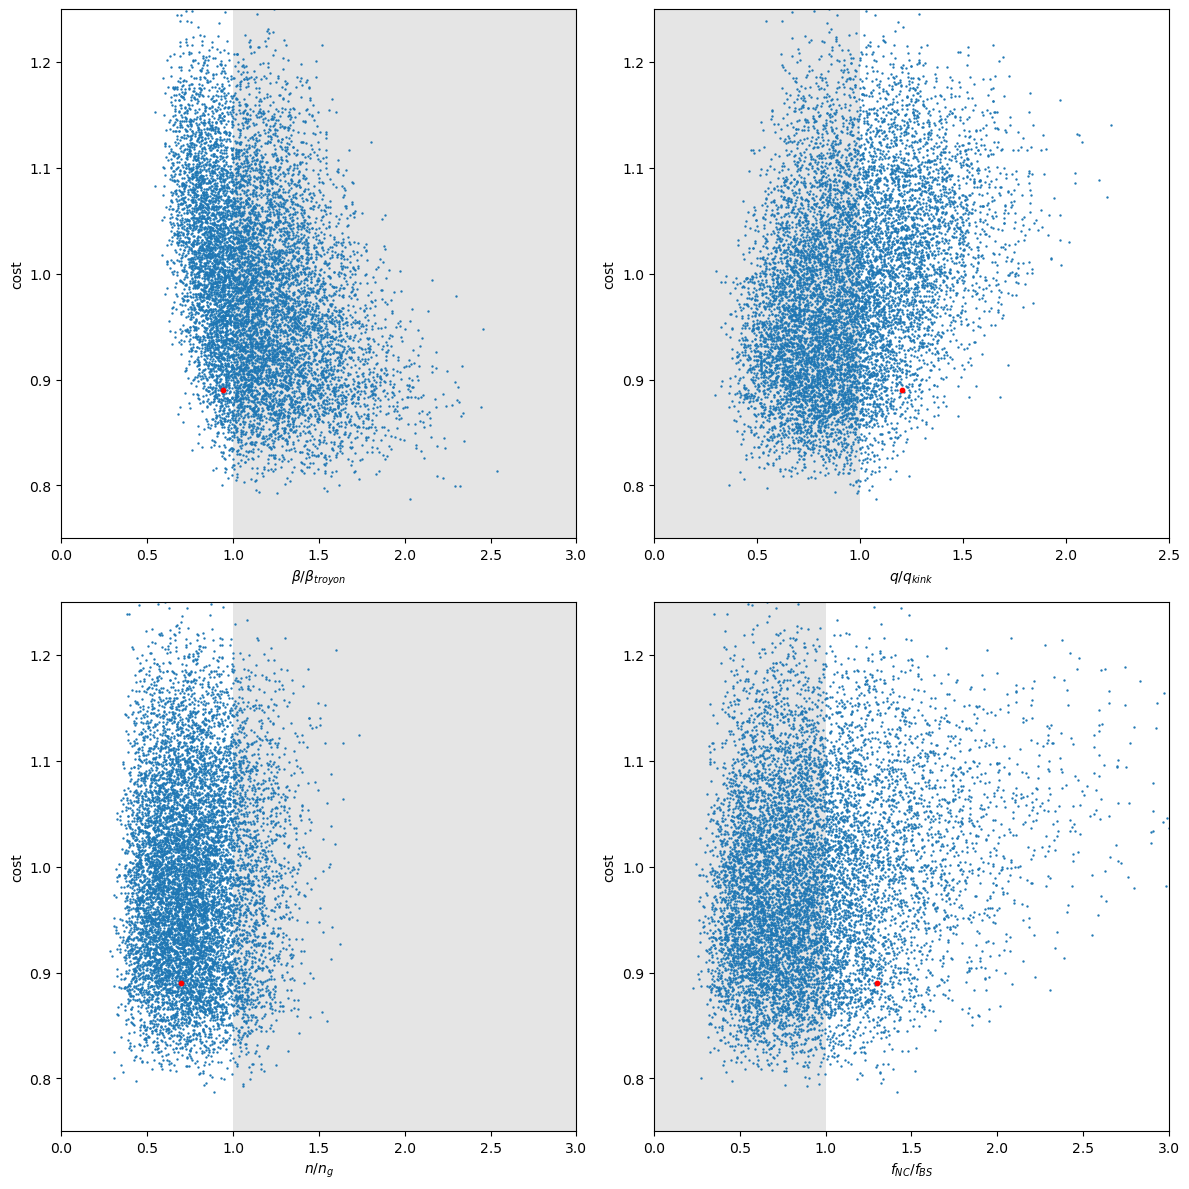

In [14]:
from src.analysis.plot import plot_scatter_feasibility

fig, axes = plot_scatter_feasibility(
    result, yparam="cost", ylabel="cost", ylims=[0.75, 1.25], filename=None
)

optim_status = result["state"][arg_min]
b_ratio = optim_status["beta"] / optim_status["beta_troyon"]
q_ratio = optim_status["q"] / optim_status["q_kink"]
n_ratio = optim_status["n"] / optim_status["n_g"]
f_ratio = optim_status["f_NC"] / optim_status["f_BS"]
cost = optim_status["cost"]

axes[0].scatter(b_ratio, cost, s=10.0, c="r")
axes[1].scatter(q_ratio, cost, s=10.0, c="r")
axes[2].scatter(n_ratio, cost, s=10.0, c="r")
axes[3].scatter(f_ratio, cost, s=10.0, c="r")

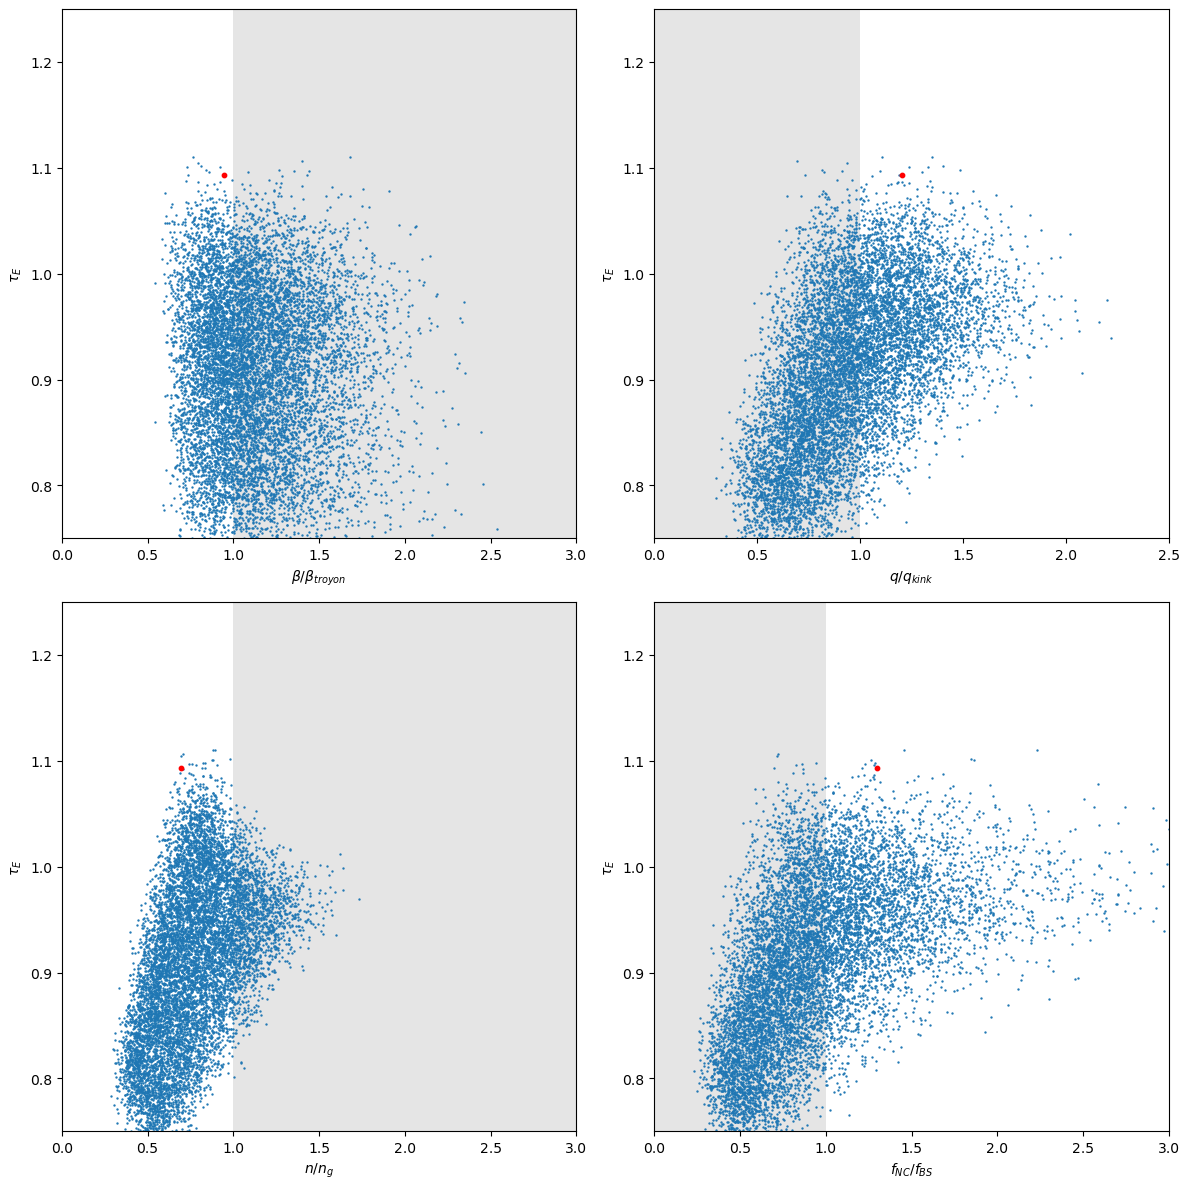

In [15]:
from src.analysis.plot import plot_scatter_feasibility

fig, axes = plot_scatter_feasibility(
    result, yparam="tau", ylabel=r"$\tau_E$", ylims=[0.75, 1.25], filename=None
)

optim_status = result["state"][arg_min]
b_ratio = optim_status["beta"] / optim_status["beta_troyon"]
q_ratio = optim_status["q"] / optim_status["q_kink"]
n_ratio = optim_status["n"] / optim_status["n_g"]
f_ratio = optim_status["f_NC"] / optim_status["f_BS"]
tau = optim_status["tau"]

axes[0].scatter(b_ratio, tau, s=10.0, c="r")
axes[1].scatter(q_ratio, tau, s=10.0, c="r")
axes[2].scatter(n_ratio, tau, s=10.0, c="r")
axes[3].scatter(f_ratio, tau, s=10.0, c="r")

In [16]:
n_operation = result["state"][arg_min]["n"]
tau_operation = result["state"][arg_min]["tau"]
T_operation = result["control"][arg_min]["T_avg"]
Q_operation = result["state"][arg_min]["Q"]
cost_operation = result["state"][arg_min]["cost"]

status_bayes = {
    "n": n_operation,
    "T": T_operation,
    "tau": tau_operation,
    "Q": Q_operation,
    "tag": "Bayesian",
    "c": "b",
    "cost": cost_operation,
    "state": result["state"],
}

In [17]:
import numpy as np
import pickle

with open("./results/rl/params_search.pkl", "rb") as f:
    result = pickle.load(f)

tau = [comp["tau"] for comp in result["state"]]
b_limit = result["b_limit"]
q_limit = result["q_limit"]
n_limit = result["n_limit"]
f_limit = result["f_limit"]
i_limit = result["i_limit"]
tbr = np.array([result["state"][idx]["TBR"] for idx in range(len(tau))])
T = np.array([result["control"][idx]["T_avg"] for idx in range(len(tau))])

tau = np.array(tau)
b_limit = np.array(b_limit)
q_limit = np.array(q_limit)
n_limit = np.array(n_limit)
f_limit = np.array(f_limit)
i_limit = np.array(i_limit)

Qs = np.array([comp['Q'] for comp in result['state']])
indices = np.where(((b_limit == 1) * (n_limit == 1) * (q_limit == 1) * (f_limit == 1) * (tbr >= 1) * (Qs > 10.0)) == 1)
print("# of feasible solutions with Q > 10:", len(indices[0]))
print('percentage of feasible solutions: {:.2f}'.format(100 * len(indices[0]) / len(tau)))

# of feasible solutions with Q > 10: 32
percentage of feasible solutions: 0.32


In [18]:
# The minimum cost case
cost = np.array([result["cost"][idx] for idx in indices[0]])

arg_min = np.argmin(cost)
arg_min = indices[0][arg_min]

for key in result["state"][arg_min].keys():
    print("{} : {:.3f}".format(key, result["state"][arg_min][key]))

for key in result["control"][arg_min].keys():
    print("{} : {:.3f}".format(key, result["control"][arg_min][key]))

R : 6.373
a : 1.768
blanket_thickness : 1.170
coil_thickness : 1.116
n : 1.247
TBR : 1.885
beta : 2.885
tau : 1.075
Ip : 14.365
q : 2.223
li : 0.029
f_BS : 0.630
Q_parallel : 693.285
n_g : 1.463
q_kink : 2.000
beta_troyon : 3.366
f_NC : 0.638
n_tau : 1.341
n_tau_lower : 2.218
cost : 1.003
Q : 10.521
betan : 3.183
k : 1.546
epsilon : 3.605
electric_power : 1471707275.391
T_avg : 14.157
B0 : 14.256
H : 1.104
armour_thickness : 0.042
RF_recirculating_rate : 0.139


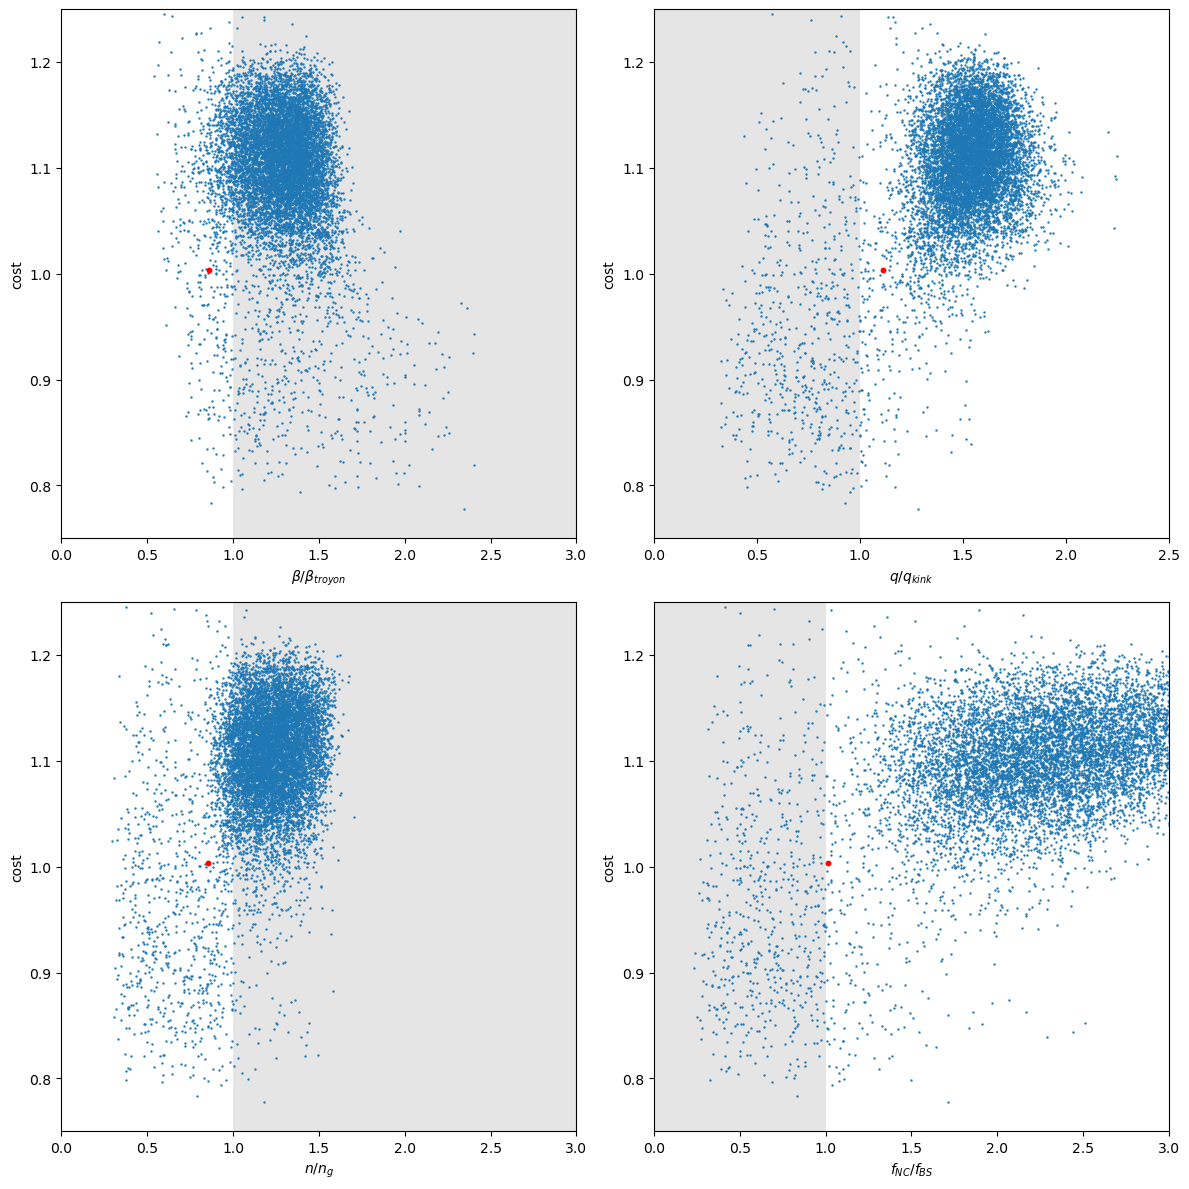

In [19]:
from src.analysis.plot import plot_scatter_feasibility

fig, axes = plot_scatter_feasibility(
    result, yparam="cost", ylabel="cost", ylims=[0.75, 1.25], filename=None
)

optim_status = result["state"][arg_min]
b_ratio = optim_status["beta"] / optim_status["beta_troyon"]
q_ratio = optim_status["q"] / optim_status["q_kink"]
n_ratio = optim_status["n"] / optim_status["n_g"]
f_ratio = optim_status["f_NC"] / optim_status["f_BS"]
cost = optim_status["cost"]

axes[0].scatter(b_ratio, cost, s=10.0, c="r")
axes[1].scatter(q_ratio, cost, s=10.0, c="r")
axes[2].scatter(n_ratio, cost, s=10.0, c="r")
axes[3].scatter(f_ratio, cost, s=10.0, c="r")

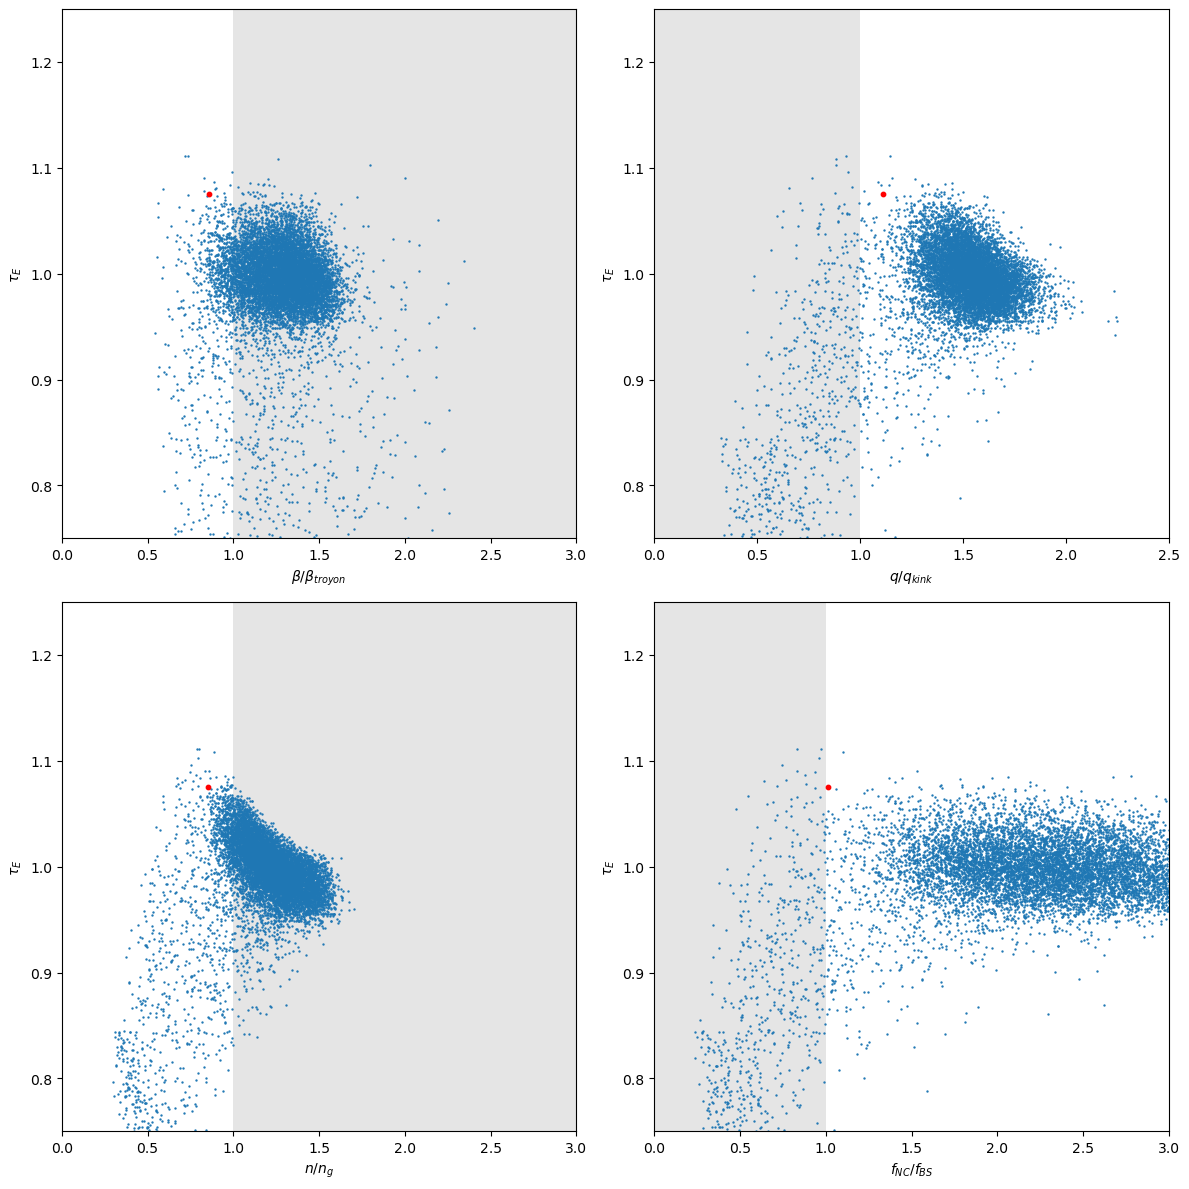

In [20]:
from src.analysis.plot import plot_scatter_feasibility

fig, axes = plot_scatter_feasibility(
    result, yparam="tau", ylabel=r"$\tau_E$", ylims=[0.75, 1.25], filename=None
)

optim_status = result["state"][arg_min]
b_ratio = optim_status["beta"] / optim_status["beta_troyon"]
q_ratio = optim_status["q"] / optim_status["q_kink"]
n_ratio = optim_status["n"] / optim_status["n_g"]
f_ratio = optim_status["f_NC"] / optim_status["f_BS"]
tau = optim_status["tau"]

axes[0].scatter(b_ratio, tau, s=10.0, c="r")
axes[1].scatter(q_ratio, tau, s=10.0, c="r")
axes[2].scatter(n_ratio, tau, s=10.0, c="r")
axes[3].scatter(f_ratio, tau, s=10.0, c="r")

In [21]:
n_operation = result["state"][arg_min]["n"]
tau_operation = result["state"][arg_min]["tau"]
T_operation = result["control"][arg_min]["T_avg"]
Q_operation = result["state"][arg_min]["Q"]
cost_operation = result["state"][arg_min]["cost"]

status_rl = {
    "n": n_operation,
    "T": T_operation,
    "tau": tau_operation,
    "Q": Q_operation,
    "tag": "RL",
    "c": "y",
    "cost": cost_operation,
    "state": result["state"],
}

In [22]:
import numpy as np
import pickle

with open("./results/crl/params_search.pkl", "rb") as f:
    result = pickle.load(f)

tau = [comp["tau"] for comp in result["state"]]
b_limit = result["b_limit"]
q_limit = result["q_limit"]
n_limit = result["n_limit"]
f_limit = result["f_limit"]
i_limit = result["i_limit"]
tbr = np.array([result["state"][idx]["TBR"] for idx in range(len(tau))])
T = np.array([result["control"][idx]["T_avg"] for idx in range(len(tau))])

tau = np.array(tau)
b_limit = np.array(b_limit)
q_limit = np.array(q_limit)
n_limit = np.array(n_limit)
f_limit = np.array(f_limit)
i_limit = np.array(i_limit)

Qs = np.array([comp['Q'] for comp in result['state']])
indices = np.where(((b_limit == 1) * (n_limit == 1) * (q_limit == 1) * (f_limit == 1) * (tbr >= 1) * (Qs > 10.0)) == 1)
print("# of feasible solutions with Q > 10:", len(indices[0]))
print('percentage of feasible solutions: {:.2f}'.format(100 * len(indices[0]) / len(tau)))

# of feasible solutions with Q > 10: 66
percentage of feasible solutions: 0.66


In [23]:
# The minimum cost case
cost = np.array([result["cost"][idx] for idx in indices[0]])

arg_min = np.argmin(cost)
arg_min = indices[0][arg_min]

for key in result["state"][arg_min].keys():
    print("{} : {:.3f}".format(key, result["state"][arg_min][key]))

for key in result["control"][arg_min].keys():
    print("{} : {:.3f}".format(key, result["control"][arg_min][key]))

R : 6.062
a : 1.659
blanket_thickness : 1.174
coil_thickness : 0.878
n : 1.278
TBR : 2.075
beta : 4.044
tau : 1.057
Ip : 15.080
q : 2.119
li : 0.022
f_BS : 0.593
Q_parallel : 622.134
n_g : 1.744
q_kink : 2.000
beta_troyon : 4.091
f_NC : 0.625
n_tau : 1.351
n_tau_lower : 2.262
cost : 0.883
Q : 10.188
betan : 2.926
k : 1.825
epsilon : 3.654
electric_power : 1485075805.664
T_avg : 13.859
B0 : 12.206
H : 1.035
armour_thickness : 0.035
RF_recirculating_rate : 0.187


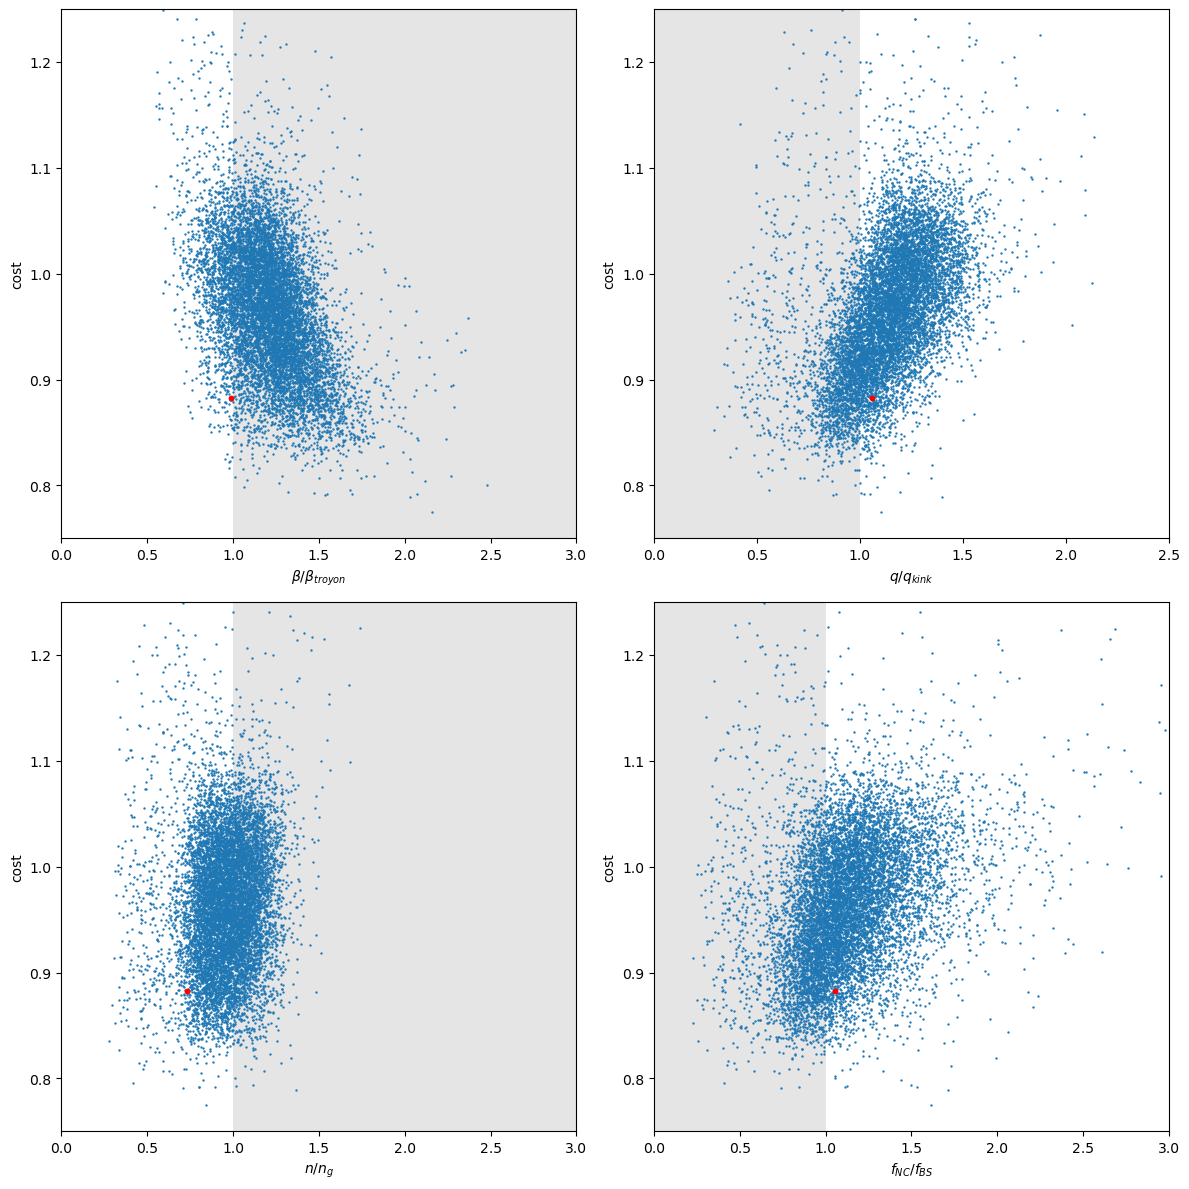

In [24]:
from src.analysis.plot import plot_scatter_feasibility

fig, axes = plot_scatter_feasibility(
    result, yparam="cost", ylabel="cost", ylims=[0.75, 1.25], filename=None
)

optim_status = result["state"][arg_min]
b_ratio = optim_status["beta"] / optim_status["beta_troyon"]
q_ratio = optim_status["q"] / optim_status["q_kink"]
n_ratio = optim_status["n"] / optim_status["n_g"]
f_ratio = optim_status["f_NC"] / optim_status["f_BS"]
cost = optim_status["cost"]

axes[0].scatter(b_ratio, cost, s=10.0, c="r")
axes[1].scatter(q_ratio, cost, s=10.0, c="r")
axes[2].scatter(n_ratio, cost, s=10.0, c="r")
axes[3].scatter(f_ratio, cost, s=10.0, c="r")

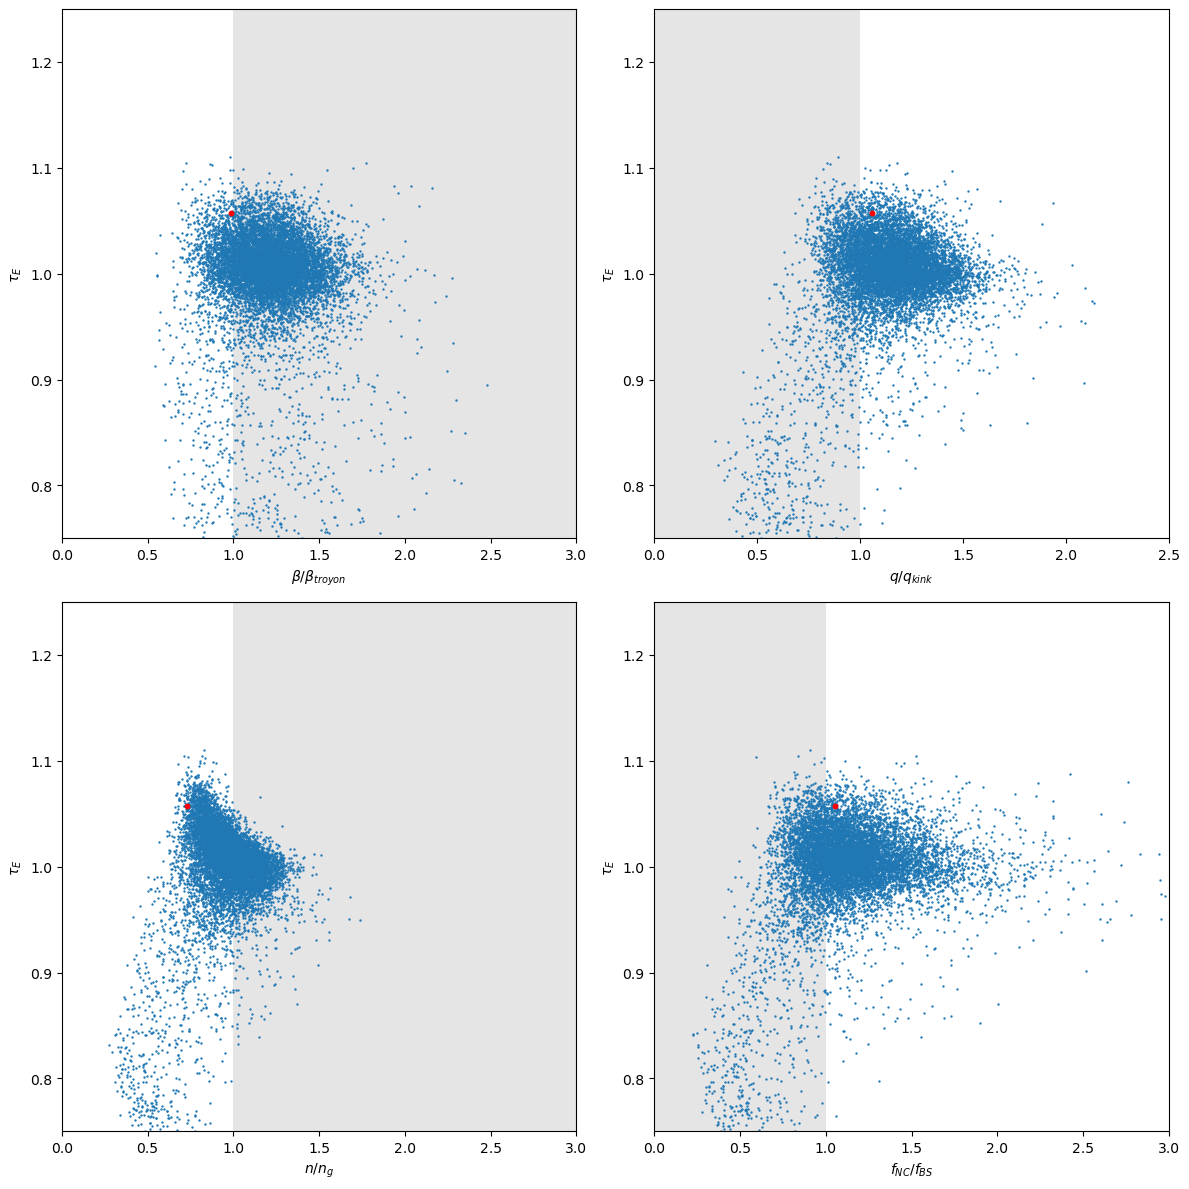

In [25]:
from src.analysis.plot import plot_scatter_feasibility

fig, axes = plot_scatter_feasibility(
    result, yparam="tau", ylabel=r"$\tau_E$", ylims=[0.75, 1.25], filename=None
)

optim_status = result["state"][arg_min]
b_ratio = optim_status["beta"] / optim_status["beta_troyon"]
q_ratio = optim_status["q"] / optim_status["q_kink"]
n_ratio = optim_status["n"] / optim_status["n_g"]
f_ratio = optim_status["f_NC"] / optim_status["f_BS"]
tau = optim_status["tau"]

axes[0].scatter(b_ratio, tau, s=10.0, c="r")
axes[1].scatter(q_ratio, tau, s=10.0, c="r")
axes[2].scatter(n_ratio, tau, s=10.0, c="r")
axes[3].scatter(f_ratio, tau, s=10.0, c="r")

In [26]:
n_operation = result["state"][arg_min]["n"]
tau_operation = result["state"][arg_min]["tau"]
T_operation = result["control"][arg_min]["T_avg"]
Q_operation = result["state"][arg_min]["Q"]
cost_operation = result["state"][arg_min]["cost"]

status_crl = {
    "n": n_operation,
    "T": T_operation,
    "tau": tau_operation,
    "Q": Q_operation,
    "tag": "CRL",
    "c": "c",
    "cost": cost_operation,
    "state": result["state"],
}

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='T(unit : keV)', ylabel='$(N\\tau_E)_{dt}(unit:10^{20}s * m^{-3})$'>)

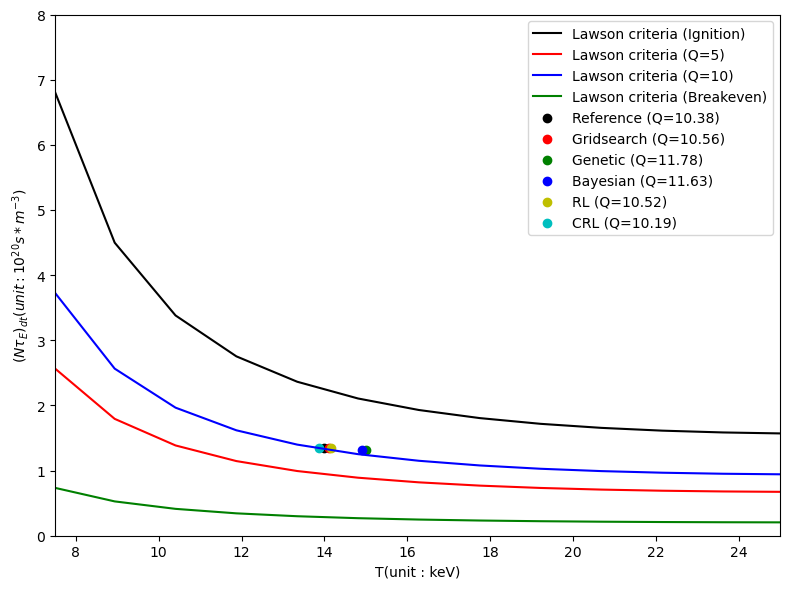

In [27]:
from src.analysis.plot import plot_lawson_curve

plot_lawson_curve(
    filename=None,
    status_list=[status_grid, status_genetic, status_bayes, status_rl, status_crl],
    xlims=[7.5, 25.0],
    ylims=[0, 8.0],
)

In [28]:
print("Cost")
print("Ref: {:.3f}".format(1.003))
print("Gri: {:.3f}".format(status_grid["cost"]))
print("Gen: {:.3f}".format(status_genetic["cost"]))
print("Bay: {:.3f}".format(status_bayes["cost"]))
print("DRL: {:.3f}".format(status_rl["cost"]))
print("CRL: {:.3f}".format(status_crl["cost"]))

print("\nConfinement")
print("Ref: {:.3f}".format(0.944))
print("Gri: {:.3f}".format(status_grid["tau"]))
print("Gen: {:.3f}".format(status_genetic["tau"]))
print("Bay: {:.3f}".format(status_bayes["tau"]))
print("DRL: {:.3f}".format(status_rl["tau"]))
print("CRL: {:.3f}".format(status_crl["tau"]))

print("\nEnergy gain Q")
print("Ref: {:.3f}".format(10.0))
print("Gri: {:.3f}".format(status_grid["Q"]))
print("Gen: {:.3f}".format(status_genetic["Q"]))
print("Bay: {:.3f}".format(status_bayes["Q"]))
print("DRL: {:.3f}".format(status_rl["Q"]))
print("CRL: {:.3f}".format(status_crl["Q"]))

Cost
Ref: 1.003
Gri: 0.863
Gen: 0.886
Bay: 0.890
DRL: 1.003
CRL: 0.883

Confinement
Ref: 0.944
Gri: 0.978
Gen: 1.097
Bay: 1.093
DRL: 1.075
CRL: 1.057

Energy gain Q
Ref: 10.000
Gri: 10.559
Gen: 11.776
Bay: 11.634
DRL: 10.521
CRL: 10.188


### Time-evoloving objective function curve

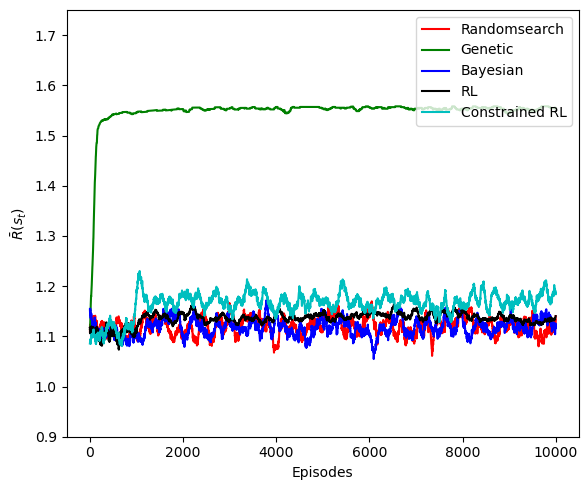

In [29]:
from src.optim.util import objective
from src.analysis.plot import temperal_average

reward_gri = [objective(state) for state in status_grid['state']]
reward_gen = [objective(state) for state in status_genetic['state']]
reward_bay = [objective(state) for state in status_bayes['state']]
reward_drl = [objective(state) for state in status_rl["state"]]
reward_crl = [objective(state) for state in status_crl["state"]]

episode = np.array(range(1, len(reward_gri)+1, 1))

# clip the invalid value
y_min = 0.0
y_max = 5.0

reward_gri = np.clip(reward_gri, a_min = y_min, a_max = y_max)
reward_gen = np.clip(reward_gen, a_min = y_min, a_max = y_max)
reward_bay = np.clip(reward_bay, a_min = y_min, a_max = y_max)
reward_drl = np.clip(reward_drl, a_min = y_min, a_max = y_max)
reward_crl = np.clip(reward_crl, a_min = y_min, a_max = y_max)

# temperal average
k = 128
reward_gri_mean, reward_gri_lower, reward_gri_upper = temperal_average(reward_gri, k)
reward_gen_mean, reward_gen_lower, reward_gen_upper = temperal_average(reward_gen, k)
reward_bay_mean, reward_bay_lower, reward_bay_upper = temperal_average(reward_bay, k)
reward_drl_mean, reward_drl_lower, reward_drl_upper = temperal_average(reward_drl, k)
reward_crl_mean, reward_crl_lower, reward_crl_upper = temperal_average(reward_crl, k)

fig = plt.figure(figsize = (6,5))

clr = plt.cm.Purples(0.9)

plt.plot(episode, reward_gri_mean, c = 'r', label = 'Randomsearch')
plt.plot(episode, reward_gen_mean, c = 'g', label = 'Genetic')
plt.plot(episode, reward_bay_mean, c = 'b', label = 'Bayesian')
plt.plot(episode, reward_drl_mean, c = 'k', label = 'RL')
plt.plot(episode, reward_crl_mean, c = 'c', label = 'Constrained RL')

plt.xlabel("Episodes")
plt.ylabel(r"$\bar{R}(s_t)$")
plt.ylim([0.9, 1.75])
plt.legend(loc = 'upper right')
fig.tight_layout()